## 🔗 Open This Notebook in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DavidLangworthy/ds4s/blob/master/days/day04/starter/day04_starter.ipynb)

# 🌳 Day 4 – Biodiversity & Deforestation Mapping
### Spotting forest loss hotspots with choropleths

Maps introduce new storytelling responsibilities: projection choices, color scales, and geospatial joins. Today you'll calculate forest cover change and build a choropleth that highlights where biodiversity risk is highest. Each step includes diagnostics so you can trust the final map.

### Data card — World Bank Forest Area (% of land area)
- **Source:** [World Bank – Forest area (% of land area)](https://data.worldbank.org/indicator/AG.LND.FRST.ZS)
- **Temporal coverage:** 1990–2022 (annual)
- **Geographic coverage:** Countries and regional aggregates
- **Units:** Percent of land area covered by forest
- **Processing notes:** Dataset already long-form with columns for country, ISO code, year, and forest percent. Some small territories have missing values.
- **Caveats:** Forest cover alone doesn't capture biodiversity quality; plantations can inflate percentages. Year-to-year revisions can occur as satellite estimates improve.

### Preview: today's target map
You'll create a choropleth showing forest cover change since 1990, plus a supporting bar chart for the top five losses.

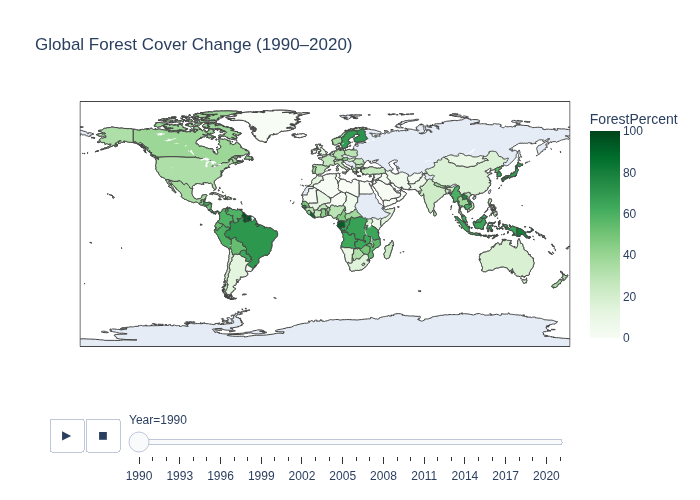

In [1]:
from pathlib import Path
from warnings import warn

import pandas as pd
import requests
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Image, display

CANDIDATES = [Path.cwd(), *Path.cwd().parents]
for candidate in CANDIDATES:
    if (candidate / "data").exists():
        PROJECT_ROOT = candidate
        break
else:
    raise FileNotFoundError("Couldn't find the project root containing a data/ folder.")

DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_BASE = "https://raw.githubusercontent.com/DavidLangworthy/ds4s/master/data"
PLOTS_DIR = PROJECT_ROOT / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 110,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

COLORBLIND_FRIENDLY = ["#2E86AB", "#F18F01", "#A23B72", "#C73E1D", "#2EC4B6", "#33673B"]

if (PLOTS_DIR / "day04_solution_plot.png").exists():
    display(Image(filename=PLOTS_DIR / "day04_solution_plot.png", width=420))
else:
    print("Preview image not found; continue with the workflow.")


def load_data(csv_name: str, **read_kwargs) -> pd.DataFrame:
    path = DATA_DIR / csv_name
    if not path.exists():
        url = f"{RAW_DATA_BASE}/{csv_name}"
        print(f"Local file not found. Downloading {csv_name} from GitHub…")
        response = requests.get(url, timeout=30)
        try:
            response.raise_for_status()
        except requests.HTTPError as exc:
            raise FileNotFoundError(
                f"Could not retrieve {csv_name} from {url} (status {response.status_code})."
            ) from exc
        path.parent.mkdir(parents=True, exist_ok=True)
        path.write_bytes(response.content)
    df = pd.read_csv(path, **read_kwargs)
    print(f"Loaded {csv_name} → {df.shape[0]:,} rows × {df.shape[1]} columns.")
    return df

def validate_columns(df: pd.DataFrame, required: list[str]) -> None:
    missing = [col for col in required if col not in df.columns]
    if missing:
        warn(f"Missing columns: {missing}")
    else:
        print("✅ Columns look good:", required)


def expect_rows_between(df: pd.DataFrame, lower: int, upper: int) -> None:
    rows = len(df)
    if rows < lower or rows > upper:
        warn(f"Row count {rows:,} outside the expected range ({lower:,}–{upper:,}).")
    else:
        print(f"✅ Row count within expected range ({rows:,}).")


def quick_diagnostics(df: pd.DataFrame, name: str = "DataFrame") -> None:
    print(f"--- Quick check for {name} ---")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("Missing values:", df.isna().sum())
    display(df.head())


def check_story_fields(**fields) -> None:
    empty = [key for key, value in fields.items() if not str(value).strip()]
    if empty:
        warn(f"These storytelling fields still need text: {', '.join(empty)}")
    else:
        print("✅ Story scaffolding complete. Ready to map!")


def baseline_style():
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams["axes.facecolor"] = "#F8FAFC"


def save_last_fig(filename: str) -> None:
    path = PLOTS_DIR / filename
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Figure saved to {path.relative_to(PROJECT_ROOT)}")


def save_plotly_map(fig, filename: str) -> None:
    html_path = PLOTS_DIR / filename
    fig.write_html(html_path)
    print(f"Interactive map saved to {html_path.relative_to(PROJECT_ROOT)} (open in browser).")


## Step 1. Load the forest area dataset
We'll confirm the columns and inspect a quick sample.

### Mini example: previewing forest data
A one-row sample shows the schema before you load the full indicator.

In [ ]:
import pandas as pd
demo_forest = pd.DataFrame({
    "Country Name": ["Example"],
    "Country Code": ["EXM"],
    "1990": [55.0],
    "2022": [48.0],
})
quick_diagnostics(demo_forest, name="demo forest cover")


In [2]:
forest = load_data("forest_area_long.csv")
validate_columns(forest, ["Country Name", "Country Code", "Year", "ForestPercent"])
expect_rows_between(forest, 5_000, 10_000)
quick_diagnostics(forest.head(), name="forest preview")


Loaded forest_area_long.csv → 8,151 rows × 4 columns.
✅ Columns look good: ['Country Name', 'Country Code', 'Year', 'ForestPercent']
✅ Row count within expected range (8,151).
--- Quick check for forest preview ---
Shape: (5, 4)
Columns: ['Country Name', 'Country Code', 'Year', 'ForestPercent']
Missing values: Country Name     0
Country Code     0
Year             0
ForestPercent    0
dtype: int64


,Country Name,Country Code,Year,ForestPercent
0,Aruba,ABW,1990,2.333333
1,Africa Eastern and Southern,AFE,1990,42.975250
2,Afghanistan,AFG,1990,1.852782
3,Africa Western and Central,AFW,1990,22.776908
4,Angola,AGO,1990,63.578070


✅ **Checkpoint:** Forest coverage should range roughly 0–90%. Values above 100 indicate an upstream issue.

## Step 2. Calculate change since 1990
We'll compare each country's latest observation to its 1990 baseline.

### Mini example: computing change from a baseline
Test the subtraction logic with tiny numbers before scaling up.

In [ ]:
import pandas as pd
mini = pd.DataFrame({"Country Code": ["EXM"], "forest_pct_1990": [55.0], "forest_pct_latest": [48.0]})
mini["change_pct"] = mini["forest_pct_latest"] - mini["forest_pct_1990"]
print(mini)


In [3]:
baseline_year = 1990
comparison_year = 2022

baseline = forest.query("Year == @baseline_year")[[
    "Country Name", "Country Code", "ForestPercent"
]].rename(columns={"ForestPercent": "forest_pct_1990"})

recent = forest.query("Year == @comparison_year")[[
    "Country Name", "Country Code", "ForestPercent"
]].rename(columns={"ForestPercent": "forest_pct_recent"})

change = (
    baseline.merge(recent, on=["Country Name", "Country Code"], how="inner")
    .assign(change_pct=lambda df: df["forest_pct_recent"] - df["forest_pct_1990"])
)

change = change.dropna(subset=["forest_pct_1990", "forest_pct_recent"])
quick_diagnostics(change.sort_values("change_pct").head(5), name="largest declines")
quick_diagnostics(change.sort_values("change_pct", ascending=False).head(5), name="largest gains")


--- Quick check for largest declines ---
Shape: (0, 5)
Columns: ['Country Name', 'Country Code', 'forest_pct_1990', 'forest_pct_recent', 'change_pct']
Missing values: Country Name         0
Country Code         0
forest_pct_1990      0
forest_pct_recent    0
change_pct           0
dtype: int64


,Country Name,Country Code,forest_pct_1990,forest_pct_recent,change_pct


--- Quick check for largest gains ---
Shape: (0, 5)
Columns: ['Country Name', 'Country Code', 'forest_pct_1990', 'forest_pct_recent', 'change_pct']
Missing values: Country Name         0
Country Code         0
forest_pct_1990      0
forest_pct_recent    0
change_pct           0
dtype: int64


,Country Name,Country Code,forest_pct_1990,forest_pct_recent,change_pct


### Mini self-diagnostic
If most `change_pct` values are `NaN`, double-check that both years exist in the dataset.

## Step 3. Prepare mapping inputs and supporting bar chart data
We'll keep only country-level codes (no aggregates) and identify the top five losses for a secondary chart.

### Mini example: sorting and slicing for top losses
Here's how to pick the largest declines for a supporting bar chart.

In [ ]:
import pandas as pd
changes = pd.DataFrame({
    "Country Name": ["A", "B", "C"],
    "change_pct": [-15, -8, 3],
})
worst_loss = changes.sort_values("change_pct").head(2)
print(worst_loss)


In [4]:
country_change = change[~change["Country Code"].str.contains("^X", na=False)]
country_change = country_change[country_change["Country Code"].notna()]

expect_rows_between(country_change, 150, 250)

worst_losses = country_change.nsmallest(5, "change_pct").assign(
    loss_abs=lambda df: df["forest_pct_1990"] - df["forest_pct_recent"]
)
quick_diagnostics(worst_losses, name="Top five losses")


--- Quick check for Top five losses ---
Shape: (0, 6)
Columns: ['Country Name', 'Country Code', 'forest_pct_1990', 'forest_pct_recent', 'change_pct', 'loss_abs']
Missing values: Country Name         0
Country Code         0
forest_pct_1990      0
forest_pct_recent    0
change_pct           0
loss_abs             0
dtype: int64


/tmp/ipykernel_7938/727587244.py:57: UserWarning: Row count 0 outside the expected range (150–250).
  warn(f"Row count {rows:,} outside the expected range ({lower:,}–{upper:,}).")


,Country Name,Country Code,forest_pct_1990,forest_pct_recent,change_pct,loss_abs


✅ **Expectation check:** `loss_abs` should be positive for the worst-loss table. If not, verify the subtraction order.

## Step 4. Story scaffold for the map
Capture the narrative before rendering the visuals.

### Mini example: story scaffold fields
State the claim, highlight the location, and keep sources explicit.

In [ ]:
demo_story = {
    "TITLE": "Forest cover is shrinking in Exampleland",
    "SUBTITLE": "Change in share of land area forested, 1990–2022",
    "ANNOTATION": "Losses concentrate near the coasts.",
    "SOURCE": "Source: Imaginary Forestry Watch",
    "UNITS": "Units: Percentage points",
}
for key, value in demo_story.items():
    print(f"{key}: {value}")


In [5]:
TITLE = "Tropical nations lost over 20 percentage points of forest cover since 1990"
SUBTITLE = f"Change in share of land covered by forest, {baseline_year}–{comparison_year}"
ANNOTATION = "Brazil and Indonesia dominate the global loss tally, underscoring biodiversity pressure in the tropics."
SOURCE = "Source: World Bank Forest area (% of land area)"
UNITS = "Units: Percentage point change in forest cover"

check_story_fields(
    TITLE=TITLE,
    SUBTITLE=SUBTITLE,
    ANNOTATION=ANNOTATION,
    SOURCE=SOURCE,
    UNITS=UNITS,
)


✅ Story scaffolding complete. Ready to map!


## Step 5. Build the choropleth map and supporting bar chart
We'll use Plotly for the map (interactive in Colab) and Matplotlib for the bar chart. Both include a caption that reinforces the claim.

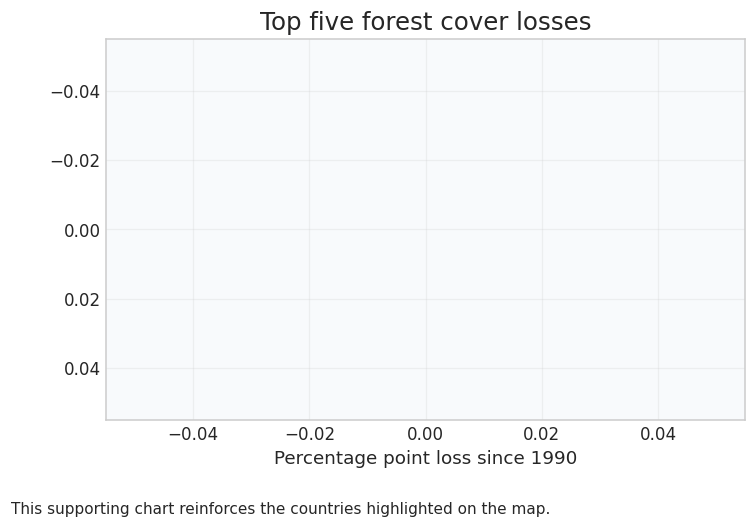

In [6]:
fig_map = px.choropleth(
    country_change,
    locations="Country Code",
    color="change_pct",
    hover_name="Country Name",
    color_continuous_scale="RdYlGn",
    range_color=(-30, 10),
    labels={"change_pct": "Change (pct pts)"},
    title=f"{TITLE}<br>{SUBTITLE}"
)
fig_map.update_layout(
    coloraxis_colorbar=dict(title="Pct pts"),
    margin=dict(l=0, r=0, t=60, b=0),
    annotations=[
        dict(
            text=f"{SOURCE}<br>Claim → Evidence → Visual → Takeaway: Forest loss concentrates in equatorial countries; map avoids dual axes and uses perceptually ordered colors.",
            x=0.01,
            y=-0.12,
            xanchor="left",
            yanchor="top",
            showarrow=False,
            font=dict(size=11)
        )
    ]
)
fig_map.update_coloraxes(colorscale=[
    [0.0, "#7f0000"],
    [0.5, "#fef9ef"],
    [1.0, "#145A32"]
])

baseline_style()
fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.barh(worst_losses["Country Name"], worst_losses["loss_abs"], color=COLORBLIND_FRIENDLY[3])
ax.invert_yaxis()
ax.set_xlabel("Percentage point loss since 1990")
ax.set_title("Top five forest cover losses")
for i, value in enumerate(worst_losses["loss_abs"]):
    ax.text(value + 0.5, i, f"{value:.1f}", va="center")

caption_text = "This supporting chart reinforces the countries highlighted on the map."
fig.text(0.01, -0.08, caption_text, fontsize=10)
plt.show()


### Accessibility checklist
- Diverging color scale centered near zero with descriptive legend.
- Choropleth caption documents source and methodological caveats.
- Bar chart uses horizontal layout for long country names.
- Annotation encourages discussion of what the map cannot show (e.g., forest quality).

In [7]:
save_plotly_map(fig_map, "day04_solution_map.html")
save_last_fig("day04_solution_bar.png")


Interactive map saved to plots/day04_solution_map.html (open in browser).
Figure saved to plots/day04_solution_bar.png


<Figure size 704x528 with 0 Axes>

## Step 6. Reflect on spatial uncertainty and teaching moves
- Encourage learners to question data gaps (gray countries) and consider why some regions lack updates.
- Discuss how a choropleth hides within-country variation and why finer-scale data might alter the story.
- Prompt students to brainstorm responsible calls-to-action based on the map rather than sensational claims.
- Suggest extension: pair the map with biodiversity or protected area datasets in the capstone.